# PROJECT: Course Optimization for Data Science
## Optimization strategies for robust regression


Author: Alexandre Gramfort

If you have questions or if something is not clear in the text below please contact us
by email.

## Aim:

- Derive mathematically and implement the loss and gradients of the Huber model
- Implement your own solvers for L1 or squared L2 regularization with: (Accelerated) Proximal gradient descent, Proximal coordinate descent and L-BFGS (only for L2).
- Implement your own scikit-learn estimator for the Huber model and test it against the Ridge and Lasso from scikit-learn on some real data.
- You are expected to provide clear figures as one could expect from an experiment section in a research paper.


## VERY IMPORTANT

This work must be done by pairs of students.
Each student must send their work before the 31st of January at 23:59, using the moodle platform.
This means that **each student in the pair sends the same file**

On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called "Project".
This is where you submit your jupyter notebook file.

The name of the file must be constructed as in the next cell

### Gentle reminder: no evaluation if you don't respect this EXACTLY

#### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "antoine"
ln1 = "habis"
fn2 = "mathis"
ln2 = "chagneux"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["project", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

project_habis_antoine_and_chagneux_mathis.ipynb


Some imports

In [55]:
%matplotlib inline
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import time
import matplotlib.image as mpimg

## Part 0: Why a robust regression model


Let us consider the problem of regression from $n$ observations
$x_i \in \mathbb{R}^{p}$,
$1 \leq i \leq n$. We aim to learn a function:
$$f: x \in \mathbb{R}^{p}\mapsto y\in\mathbb{R}$$
from the $n$ annotated training samples $(x_{i},y_{i})$ supposed i.i.d. from an unknown probability distribution on $\mathbb{R}^p \times \mathbb{R}$. Once this function is learnt, it will be possible to use it to predict the label $y$ associated to a new sample $x$.

The types of model we consider in this project are so-called *robust models* that can deal with samples corrupted by strong artifacts.

Let's generate such a dataset in 1D to illustrate the problem when using the squared loss ($\|\cdot\|^2$).

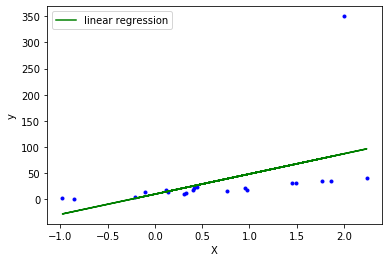

In [3]:
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression

# Generate toy data
X, y = make_regression(n_samples=20, n_features=1, random_state=0,
                       noise=4.0, bias=10.0)

# Add an outlier
X[0, 0] = 2.
y[0] = 350

# Fit the model
reg = LinearRegression()
reg.fit(X, y)

# Visualize the model
x = X[:, 0]

y_pred = reg.coef_ * x + reg.intercept_
plt.plot(x, y, 'b.')
plt.plot(x, y_pred, 'g-', label="linear regression")
plt.xlabel("X")
plt.ylabel("y")
plt.legend(loc=0)
plt.show()

In [4]:
print(reg.intercept_)

9.919390944445563


<div class="alert alert-success">
    <b>QUESTION 0:</b>
     <ul>
       <li>Describe the issue you observe and suggest an explanation and a possible solution.</li>
    </ul>
</div>

* The point of coordinates (2, 350) is an outlier: it has an extreme y coordinate. 
* In our case this outlier has a lot of influence on the final prediction because it is a point of high leverage due to its extreme X position. We can give an explanation of leverage with a brief analysis. If $x'$ and $y'$ are the recentered points, then we are solving: $$\widehat{\theta'} = argmin_{\theta'} \sum_i(y_i' - \theta' x_i')^2 = argmin_{\theta'}\sum_i x_i'^2(\frac{y_i'}{x_i'} - \theta')^2$$ ie. $$\widehat{\theta'} = \frac{\sum_i x_i'^2\frac{y'_i}{x_i'}}{\sum_j x_j'^2}$$
The $\frac{y'_i}{x_i'}$ are the slopes of the lines passing through the points and the center, thus the estimation is a weighted average of these different slopes with weights proportional to $x_i^2$. In our situation our outlier has a very high slope associated with a very high weight which gives it a lot of influence on the regression.
* As a solution, one cound use a loss function different than the squared norm for regions where X is big, so that the leverage of the points is lower in those regions.


## Part 1: Huber Loss

One version of the Huber function ($H_\epsilon : \mathbb{R} \rightarrow \mathbb{R}$) reads:

$$
    H_\epsilon (x) = \left\{
	\begin{aligned}
	x^2 & \quad \mathrm{ if } \quad |x| < \epsilon \\
    2 \epsilon |x| - \epsilon^2 & \quad \mathrm{ otherwise }
	\end{aligned}
    \right.
$$

Working in a regression setting, the Huber loss between 2 targets $y$ and $y'$ reads:

$$
    \mathcal{L}(y, y') = H_\epsilon (y - y')
$$

Here is an implemention of the Huber function:

In [5]:
epsilon = 1

def huber(x, epsilon):
    mask = np.abs(x) < epsilon
    z = x.copy()
    z[mask] = x[mask] ** 2
    z[~mask] = 2 * epsilon * np.abs(x[~mask]) - epsilon ** 2
    return z

<div class="alert alert-success">
    <b>QUESTION 1:</b>
     <ul>
       <li>Plot the Huber function vs. the squared function ($x \rightarrow x^2$) vs. the absolute value function ($x \rightarrow |x|$) between -3 and 3 using $\epsilon = 1$</li>
    </ul>
</div>

INSERT YOUR ANSWER HERE

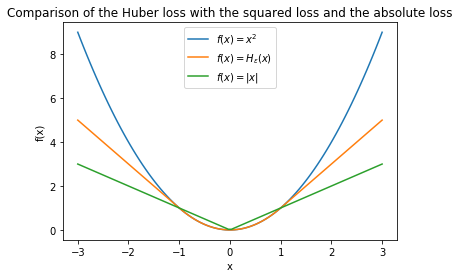

In [6]:
### TODO
x = np.linspace(-3,3,100)
plt.plot(x,x**2,label = '$f(x) =  x^2$')
plt.plot(x,huber(x,epsilon = epsilon),label = '$f(x) =  H_{\epsilon}(x)$')
plt.plot(x,np.abs(x),label = '$f(x) =|x|$')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Comparison of the Huber loss with the squared loss and the absolute loss')
plt.legend()
plt.show()

### END TODO

<div class="alert alert-success">
    <b>QUESTION 2:</b>
     <ul>
       <li>Justify the convexity of the Huber function as defined above.</li>
       <li>Justify the smoothness of the Huber function as defined above and propose a value of for the Lipschitz constant of its gradient.</li>
    </ul>
</div>

* Visually we see that the graph of $H_{\epsilon}$ is above all its tangents : that's one definition of convexity, so the Huber function is convex. Analytically we have that $H_{\epsilon}'' = 2\mathbb{1}_{]-\epsilon,\epsilon[} \geq 0$ which confirms that $H_{\epsilon}$ is convex.
* Visually we see that we can fit the graph of a quadratic function above the graph of $H_{\epsilon}$: that's one definition of smoothness, so the Huber function is smooth. Analytically we see that $H_{\epsilon}'' \leq 2$ which confirms that $H_{\epsilon}$ is smooth and we can propose $L = 2$ for the smoothness constant (which is equal to the Lipschitz constant of the gradient).

<div class="alert alert-success">
    <b>QUESTION 3:</b>
     <ul>
       <li>Write a function that computes the gradient of the Huber loss.</li>
    </ul>
</div>

**Remark:** You will use the `scipy.optimize.check_grad` function to assess the validity of your result. You will need to test your gradient in both the linear and quadratic regions of the Huber function (not just in one location).

INSERT YOUR ANSWER HERE

In [7]:
### TODO

## the version of the huber function which applies on a single value (needed to use check_grad apparently)
def huber_value(x):
    if np.abs(x) < epsilon:
        return x**2
    return 2 * epsilon * np.abs(x) - epsilon ** 2


## the version of the gradient which applies on a single value (needed to use check_grad apparently)
def grad_huber_value(x):# END TODO


    if np.abs(x) < epsilon:
        return 2*x
    elif x >= epsilon:
        return 2*epsilon
    return -2*epsilon

# the version of the gradient which applies the gradient to each element of the vector in an effective way
def grad_huber(x,epsilon):
    middle = np.abs(x) < epsilon
    z = x.copy()
    z[middle] = 2*x[middle]
    z[x >= epsilon] = 2*epsilon
    z[x <= -epsilon] = -2*epsilon
    return z


from scipy.optimize import check_grad
print('Error on gradient for a value in [-eps,eps]',check_grad(huber_value, grad_huber_value, np.array([epsilon-epsilon/2])))
print('Error on gradient for a value > eps',check_grad(huber_value, grad_huber_value, np.array([epsilon+1])))
print('Error on gradient for a value < -eps',check_grad(huber_value, grad_huber_value, np.array([-epsilon-1])))

### END TODO

Error on gradient for a value in [-eps,eps] 1.4901161193847656e-08
Error on gradient for a value > eps 0.0
Error on gradient for a value < -eps 0.0


In [8]:
grad_huber(np.array([-1.2,0,5]),1)

array([-2.,  0.,  2.])

Let us define the cost function associated to the empirical risk with some regularization function $\mathcal{R}$:

$$
    (\mathcal{P}_{f,\mathcal{R}}):
	\begin{aligned}
	\min_{w \in \mathbb{R}^p, b \in \mathbb{R}} \quad \frac{1}{n} \sum_{i=1}^n f(y_i - x_i^\top w - b) + \lambda \mathcal{R}(w) \enspace ,
	\end{aligned}
$$

where $f$ is a scalar function defining the loss (Huber, squared, absolute etc.). The variable $b$ is the bias or intercept term.

<div class="alert alert-success">
    <b>QUESTION 4:</b>
     <ul>
      <li>Let us consider for $\mathcal{R}$ either the $\ell_1$ norm ($\mathcal{R}_1(w) = \|w\|_1 = \sum_{j=1}^p |w_j|$) or the squared $\ell_2$ norm ($\mathcal{R}_2(w) = \|w\|_2^2 = \sum_{j=1}^p w_j^2)$. Justify what optimization strategy among L-BFGS, (proximal-)gradient descent, (proximal-)coordinate descent is readily applicable, depending on the choice of $\mathcal{R}$ when $f$ is the Huber function as defined above.</li>
    </ul>
</div>

**First** let's define:
* $f_i(w) = f(y_i - x_i^\top w - b)$
* $F(w) = \sum_i f_i(w)$
* $R_i$ such that $R(w) = \sum_i R_i(w)$

$\forall i \in [1,..,n], f_i$ is differentiable and convex and the L1 and L2 norms are also convex. 

f is also L-smooth (with L = 2) so the $f_i$ and $F$ are also smooth (we'll determine the smoothness constant later).

Let's see what different requirements are needed for running the algorithms :

**L-BFGS:**
- $\forall i \in [1,...,n], f_i+R_i$ is convex and twice differentiable in $\mathbb{R}^d$
- $\forall i \in [1,...,n], f_i$ is $\mu_i$ strongly convex and $L_i-smooth$ on $\mathbb{R}^d$ and $ 0<\mu_i<L_i$

**Proximal gradient descent:**
- F is differentiable, L-smooth and convex
- R is convex and "prox-friendly"

**Gradient descent:**
- F+R is convex or $\mu$-strongly convex and L-smooth 

**Coordinate descent:**( _Warga(1963)_ )
- $F+R$ is $C^1$
- $F+R$ is strictly convex
- $\exists x_{*} \in argmin_{x \in X} F+R(x)$


**Proximal coordinate descent:**
- F has to be convex and differentiable
- R is composite (w.r.t the features) and each one-dimensional $R_j$ is convex
- F is L-smooth

**Thus for the L1 norm we can use the following algorithms:**
- the proximal gradient descent
- the proximal coordinate descent (which should perform better given complexity theorems)

**For the L2 norm we can use the following algorithms:**
- all of them, and L-BFGS is expected to have the best performance

<div class="alert alert-success">
    <b>QUESTION 5:</b>
    <ul>
    <li>
        Taking as $f$ the Huber function and the $\mathcal{R}_2$ regularization function, solve the optimization prolem $(\mathcal{P}_{H_\epsilon,\mathcal{R}_2})$ using the `fmin_l_bfgs_b` function from `scipy.optimize`. You are expected to provide the explicit gradient (fprime parameter) to `fmin_l_bfgs_b`.
    </li>
    <li>Using the simulated dataset from above, you will check that your solver fixes the problem of the outlier provided that $\lambda$ is small enough (eg. $\lambda = 0.01$). Your are expected to make a plot of the regression fit.</li>
    </ul>
</div>

The estimate of $w$ and $b$ should be called `w_hat` and `b_hat`. You will call the regularization parameter $\lambda$ as `lbda` in the code.

To help you we provide you with the function `pobj_l2` that computes the primal objective to minimize. Note that the parameters `w` and `b` are combined in a single array `params`.

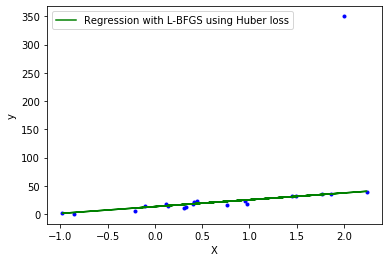

In [9]:
from scipy.optimize import fmin_l_bfgs_b

lbda = 0.01

# the objective function when X and x are the matrix and vectors of the problem with the first feature corresponding to the intercept
def pobj_l2(x, X, y, lbda, epsilon):
    return np.mean(huber(y - np.dot(X, x), epsilon = epsilon)) + lbda * np.sum(x[1:] ** 2)


# gradient of the objective function
def grad_pobj_l2(x, X, y, lbda, epsilon):
    grad = - X.T @ grad_huber(y - np.dot(X,x), epsilon)/X.shape[0] 
    grad[1:] += 2*lbda*x[1:]
    return grad
        
def huber_lbfgs_l2(X, y, lbda, epsilon):
    # TODO
    params_0 = np.zeros(X.shape[1])
    params_0[0] = np.mean(y)
    params_min, pobj_l2_min, _ = fmin_l_bfgs_b(func = pobj_l2, x0 = params_0, fprime = grad_pobj_l2, args = (X,y,lbda,epsilon))
    
    # END TODO
    return params_min, pobj_l2_min

X_prime = np.concatenate((np.ones((X.shape[0],1)),X),axis = 1) # we use a constant feature to deal with the intercept
params_min, pobj_l2_min = huber_lbfgs_l2(X=X_prime,y=y,lbda=lbda,epsilon=epsilon)
b_hat = params_min[0]
w_hat = params_min[1:]
x = X[:, 0]
y_pred = w_hat * x + b_hat

# TODO  (for visualization)

plt.plot(x, y, 'b.')
plt.plot(x, y_pred, 'g-', label="Regression with L-BFGS using Huber loss")
plt.xlabel("X")
plt.ylabel("y")
plt.legend(loc=0)
plt.show()

# # END TODO

The problem seems solved for this value of $\lambda$

## Part 2: Huber Loss with L1 regularization

In this section we are interested in the $\ell_1$ regularized model.
To help you we give you the code of the objective function to minimize.

In [10]:
def pobj_l1(x, X=X, y=y, lbda=lbda, epsilon=epsilon):
    return np.mean(huber(y - np.dot(X, x), epsilon=epsilon)) + lbda * np.sum(np.abs(x[1:])) # we modified the function sligtly to deal with our added constant feature

Now that we have the cost function, you are going to implement solvers based on:

- Proximal Gradient Descent (PGD aka ISTA)
- Accelerated Proximal Gradient Descent (APGD aka FISTA)
- Proximal Coordinate Descent (PCD)

Before this we are going to define the `monitor` class previously used in the second lab as well as plotting functions useful to monitor convergence.

In [11]:
class monitor(object):
    def __init__(self, algo, obj, x_min, args=()):
        self.x_min = x_min
        self.algo = algo
        self.obj = obj
        self.args = args
        if self.x_min is not None:
            self.f_min = obj(x_min, *args)

    def run(self, *algo_args, **algo_kwargs):
        t0 = time.time()
        _, x_list = self.algo(*algo_args, **algo_kwargs)
        self.total_time = time.time() - t0
        self.x_list = x_list
        if self.x_min is not None:
            self.err = [linalg.norm(x - self.x_min) for x in x_list]
            self.obj = [linalg.norm(self.obj(x, *self.args) - self.f_min) for x in x_list]
        else:
            self.obj = [self.obj(x, *self.args) for x in x_list]


def plot_epochs(monitors, solvers):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    for monit in monitors:
        ax1.semilogy(monit.obj, lw=2)
        ax1.set_title("Objective")
        ax1.set_xlabel("Epoch")
        if monit.x_min is None:
            ax1.set_ylabel("$f(x_k)$")
        else:
            ax1.set_ylabel("$f(x_k) - f(x^*)$")

    ax1.legend(solvers)

    for monit in monitors:
        if monit.x_min is not None:
            ax2.semilogy(monit.err, lw=2)
            ax2.set_title("Distance to optimum")
            ax2.set_xlabel("Epoch")
            ax2.set_ylabel("$\|x_k - x^*\|_2$")

    ax2.legend(solvers)


def plot_time(monitors, solvers):
    for monit in monitors:
        objs = monit.obj
        plt.semilogy(np.linspace(0, monit.total_time, len(objs)), objs, lw=2)
        plt.title("Loss")
        plt.xlabel("Timing")
        plt.ylabel("$f(x_k) - f(x^*)$")

    plt.legend(solvers)

<div class="alert alert-success">
    <b>QUESTION 6a:</b>
    <ul>
    <li>
        Implement the proximal gradient descent (PGD) method.
    </li>
    </ul>
</div>

**Note:**  The parameter `step` is the size of the gradient step that you will need to propose by computing the Lipschitz constant of the data fitting term (Huber term without regularization term).

In [12]:
def pgd(x_init, grad, prox, step, n_iter=100, store_every=1,
        grad_args=(), prox_args=()):
    """Proximal gradient descent algorithm.
    
    Parameters
    ----------
    x_init : array, shape (n_parameters,)
        Parameters of the optimization problem.
    grad : callable
        The gradient of the smooth data fitting term.
    prox : callable
        The proximal operator of the regularization term.
    step : float
        The size of the gradient step done on the smooth term.
    n_iter : int
        The number of iterations.
    store_every : int
        At which frequency should the current iterated be remembered.
    grad_args : tuple
        Parameters to pass to grad.
    prox_args : tuple
        Parameters to pass to prox.
    
    Returns
    -------
    x : array, shape (n_parameters,)
        The estimated parameters.
    x_list : list
        The list if x values along the iterations.
    """
    x = x_init.copy()
    x_list = []
    for i in range(n_iter):
        ### TODO
        x = prox(x - step*grad(x,*grad_args),step,*prox_args) # PGD step 
        ### END TODO
        if i % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

<div class="alert alert-success">
    <b>QUESTION 6b:</b>
    <ul>
    <li>
        Implement the L1 and L2 proximal operators. You will pay attention to the intercept.
    </li>
    <li>
        Using the monitor class and the plot_epochs function, display the convergence.
    </li>
    </ul>
</div>

In order to get a good value of `x_min` you will let your PGD solver run for 10000 iterations.

First you will need to implement the proximal operator functions for $\ell_1$ and $\ell_2$ regularized models.

In [13]:
def prox_R2(params, reg=1.):
    # TODO
    params[1:] = params[1:]/(1+2*reg) # we only take the prox of the parameters not corresponding to intercept
    # END TODO
    return params

def prox_R1(params, reg=1.):
    # TODO
    params[1:] = np.sign(params[1:]) * np.maximum(np.abs(params[1:]) - reg, 0.) # idem 
    # END TODO
    return params

def prox_l2(params, step, lbda):
    return prox_R2(params, reg=step * lbda)


def prox_l1(params, step, lbda):
    return prox_R1(params, reg=step * lbda)

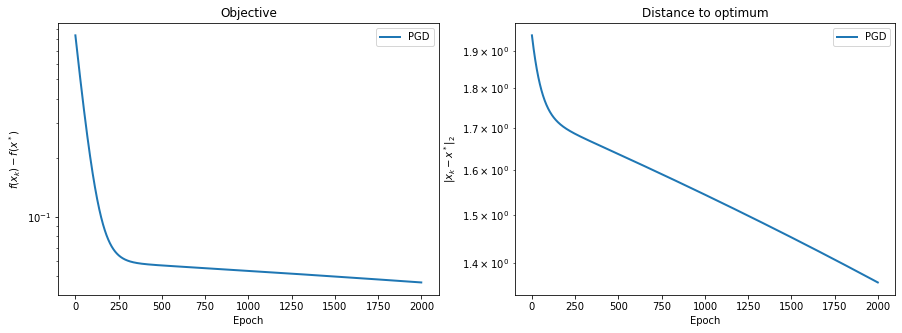

In [14]:
# Generate bigger data
X, y = make_regression(n_samples=500, n_features=100, random_state=0,
                       noise=4.0, bias=10.0)
X = np.concatenate((np.ones((500,1)),X),axis = 1) # adding a constant feature to include the intercept in x 
n_samples, n_features = X.shape # n_features is now increased by 1

# Set initial values of parameters to optimize
x_init = np.zeros(n_features)
x_init[0] = np.mean(y)
n_iter = 2000
lbda = 1.
epsilon = 1.

# TODO


def grad_huber_loss(x, X, y, epsilon):
    grad = - X.T @ grad_huber(y - np.dot(X,x), epsilon)/X.shape[0] # simple forumulation of the gradient when b is included in x
    return grad

L_huber = 2 # smoothness constant of the Huber function 
L_loss = (L_huber / n_samples) * (X**2).sum() # smoothness constant of the objective function obtain with L = sum L_i if f = sum f_i
step = 1/L_loss

x_min_pgd_l2 = pgd(x_init, grad_huber_loss, prox_l2, step, 10000,
                   grad_args=(X, y,epsilon), prox_args=(lbda,))[0]

# END TODO

# Run PGD
monitor_pgd_l2 = monitor(pgd, pobj_l2, x_min_pgd_l2, args=(X, y, lbda,epsilon))
monitor_pgd_l2.run(x_init, grad_huber_loss, prox_l2, step, n_iter,
                   grad_args=(X, y,epsilon), prox_args=(lbda,))

monitors = [monitor_pgd_l2]
solvers = ["PGD"]
plot_epochs(monitors, solvers)

Now for the $\ell_1$ regularization:

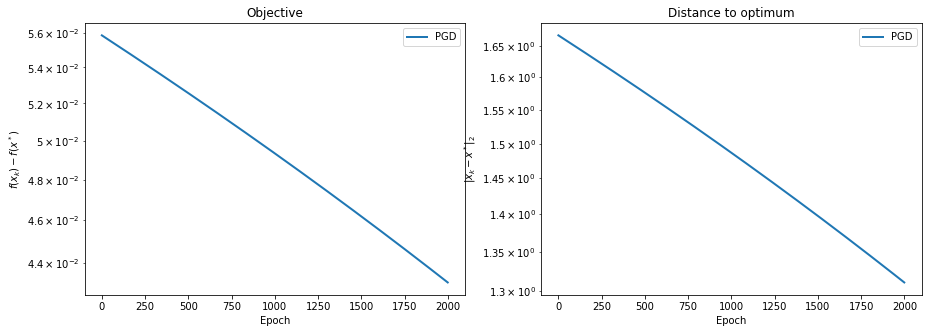

In [15]:
# Run PGD for L1
x_init = np.zeros(n_features)
x_init[0] = np.mean(y)

x_min_pgd_l1 = pgd(x_init, grad_huber_loss, prox_l1, step, 10000,
                   grad_args=(X, y, epsilon), prox_args=(lbda,))[0]

monitor_pgd_l1 = monitor(pgd, pobj_l1, x_min = x_min_pgd_l1, args=(X, y, lbda,epsilon))
monitor_pgd_l1.run(x_init, grad_huber_loss, prox_l1, step, n_iter,
                   grad_args=(X, y,epsilon), prox_args=(lbda,))


monitors = [monitor_pgd_l1]
solvers = ["PGD"]
plot_epochs(monitors, solvers)

<div class="alert alert-success">
    <b>QUESTION 7:</b>
    <ul>
    <li>
        Implement the accelerated proximal gradient descent (APGD) and add this solver to the monitoring plots.
    </li>
    </ul>
</div>

In [16]:
def apgd(x_init, grad, prox, step, n_iter=100, store_every=1,
         grad_args=(), prox_args=()):
    """Accelerated proximal gradient descent algorithm."""
    x = x_init.copy()
    y = x_init.copy()
    t = 1.
    x_list = []
    for i in range(n_iter):
        ### TODO
        x_new = prox(y - step*grad(y,*grad_args),step,*prox_args)
        t_new = (1 + np.sqrt(1+4*t**2))/2
        y = x_new + (t-1)*(x_new - x)/t_new
        x = x_new
        t = t_new
        ### END TODO
        if i % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

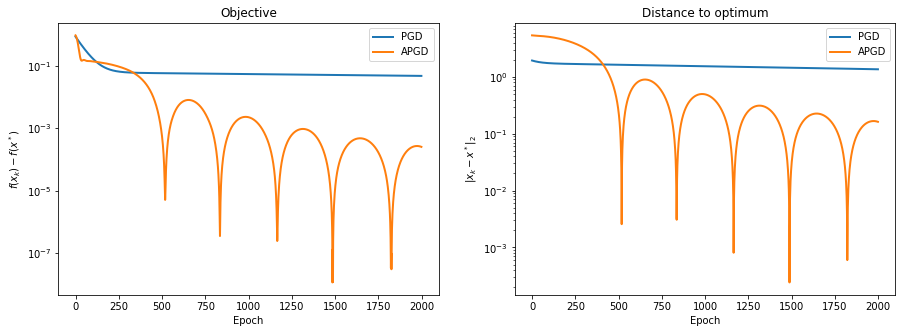

In [17]:
# TODO

x_min_apgd_l2 = apgd(x_init, grad_huber_loss, prox_l2, step, 10000,
                   grad_args=(X, y,epsilon), prox_args=(lbda,))[0]

monitor_apgd_l2 = monitor(apgd, pobj_l2, x_min  = x_min_apgd_l2, args=(X, y, lbda,epsilon))
monitor_apgd_l2.run(x_init, grad_huber_loss, prox_l2, step, n_iter,
                   grad_args=(X, y,epsilon), prox_args=(lbda,))


# END TODO
monitors = [monitor_pgd_l2, monitor_apgd_l2]
solvers = ["PGD", "APGD"]
plot_epochs(monitors, solvers)

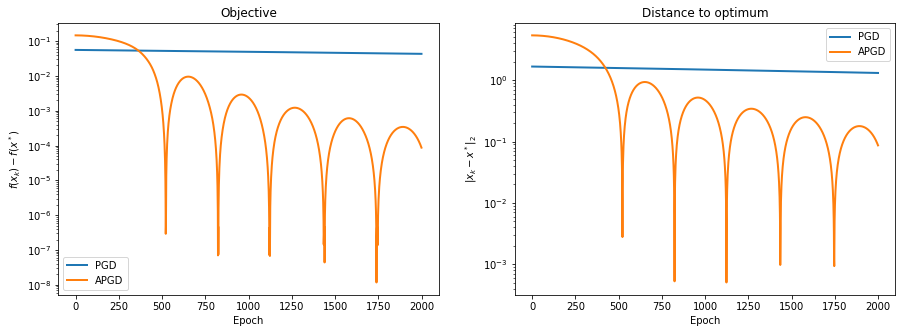

In [18]:
x_min_apgd_l1 = apgd(x_init, grad_huber_loss, prox_l1, step, 10000,
                   grad_args=(X, y,epsilon), prox_args=(lbda,))[0]

monitor_apgd_l1 = monitor(apgd, pobj_l1, x_min_apgd_l1, args=(X, y, lbda,epsilon))
monitor_apgd_l1.run(x_init, grad_huber_loss, prox_l1, step, n_iter,
                   grad_args=(X, y, epsilon), prox_args=(lbda,))

monitors = [monitor_pgd_l1, monitor_apgd_l1]
solvers = ["PGD", "APGD"]
plot_epochs(monitors, solvers)

<div class="alert alert-success">
    <b>QUESTION 8:</b>
    <ul>
    <li>
        Implement the proximal coordinate descent (PCD) and add this solver to the monitoring plots for L1 and L2 regularized models.
    </li>
    </ul>
</div>

**Note:** You are welcome to try to use numba to get reasonable performance but don't spend too much time if you get weird numba errors.

In [19]:
from numba import njit
@njit

# we have to reimplement the prox functions for the 1D case needed to use PCD 
def prox_R2_1D(params, reg=1.):
    # TODO
    params = params/(1+2*reg)
    # END TODO
    return params

def prox_R1_1D(params, reg=1.):
    # TODO
    params = np.sign(params) * np.maximum(np.abs(params) - reg, 0.)
    # END TODO
    return params


def prox_l2_1D(params, step, lbda):
    return prox_R2_1D(params, reg=step * lbda)

def prox_l1_1D(params, step, lbda):
    return prox_R1_1D(params, reg=step * lbda)

def grad_huber_loss_j(x, j, Xx, X, y, epsilon):
    # intelligent update of the gradient : don't compute the full gradient to extract one component but compute only the desired component
    # and use the intelligently computed Xx for the grad_huber part.
    return -X[:,j].T @ grad_huber(y - Xx, epsilon)/X.shape[0] 

def pcd(x_init, X, grad, prox, steps, n_iter=100, store_every=1,
        grad_args=(), prox_args=()):
    """Proximal coordinate descent algorithm.
    
    Parameters
    ----------
    x_init : array, shape (n_parameters,)
        Parameters of the optimization problem.
    grad : callable
        The gradient of the smooth data fitting term.
    prox : callable
        The proximal operator of the regularization term.
    step : float
        The size of the gradient step done on the smooth term.
    n_iter : int
        The number of iterations.
    store_every : int
        At which frequency should the current iterated be remembered.
    grad_args : tuple
        Parameters to pass to grad.
    prox_args : tuple
        Parameters to pass to prox.
    
    Returns
    -------
    x : array, shape (n_parameters,)
        The estimated parameters.
    x_list : list
        The list if x values along the iterations.
    """
    x = x_init.copy()
    x_list = []
    Xx = np.dot(X,x)
    for i in range(n_iter):
        ### TODO
        for j in range(X.shape[1]): # we cycle through the features 
            old_x_j = x[j] # storing old value for intelligent update 
            if j != 0:
                x[j] = prox(x[j] - steps[j]*grad(x,j,Xx,*grad_args),steps[j],*prox_args) # update of one component
            else:
                x[j] = x[j] - steps[j]*grad(x,j,Xx,*grad_args) # update of one component

            Xx +=  (x[j] - old_x_j)*X[:,j] # intelligent update of Xx because only one component of x changes per iteration so no need to recompute the full dot product at each iteration
        ### END TODO
        if i % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

# END TODO

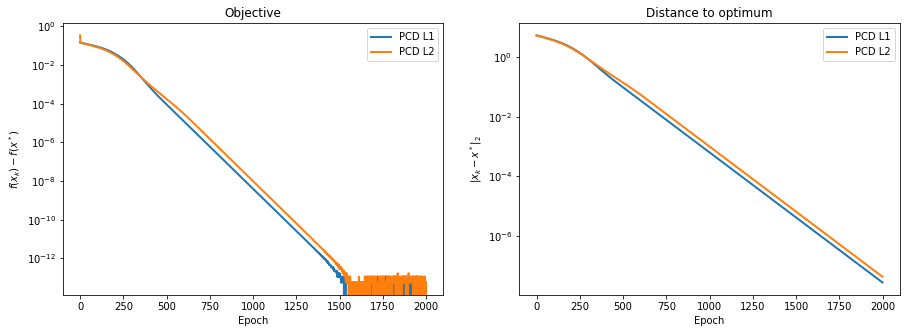

In [20]:
L_loss = (L_huber / n_samples) * (X**2).sum(axis = 0)
steps = 1/L_loss

x_init = np.zeros(n_features)
x_init[0] = np.mean(y)


x_min_pcd_l2 = pcd(x_init, X, grad_huber_loss_j, prox_l2_1D, steps, 10000,
                   grad_args=(X, y, epsilon), prox_args=(lbda,))[0]

monitor_pcd_l2 = monitor(pcd, pobj_l2, x_min_pcd_l2, args=(X, y, lbda, epsilon))
monitor_pcd_l2.run(x_init, X, grad_huber_loss_j, prox_l2_1D, steps, n_iter,
                   grad_args=(X, y, epsilon), prox_args=(lbda,))

x_min_pcd_l1 = pcd(x_init, X, grad_huber_loss_j, prox_l1_1D, steps, 10000,
                   grad_args=(X, y, epsilon), prox_args=(lbda,))[0]

monitor_pcd_l1 = monitor(pcd, pobj_l1, x_min_pcd_l1, args=(X, y, lbda, epsilon))
monitor_pcd_l1.run(x_init, X, grad_huber_loss_j, prox_l1_1D, steps, n_iter,
                   grad_args=(X, y, epsilon), prox_args=(lbda,))
# END TODO
monitors = [monitor_pcd_l1,monitor_pcd_l2]
solvers = ["PCD L1","PCD L2"]
plot_epochs(monitors, solvers)

In [21]:
def performance_comparison(N_samples,N_features):
    
        # Generate bigger data
    X, y = make_regression(n_samples=N_samples, n_features=N_features, random_state=0,
                           noise=4.0, bias=10.0)
    X = np.concatenate((np.ones((N_samples,1)),X),axis = 1)
    n_samples, n_features = X.shape

    # Set initial values of parameters to optimize
    x_init = np.zeros(n_features)
    x_init[0] = np.mean(y)
    n_iter = 2000
    lbda = 1.
    epsilon = 1.


    L_huber = 2 # smoothness constant of the Huber function 
    L_loss = (L_huber / n_samples) * (X**2).sum()
    step = 1/L_loss

    L_loss = (L_huber / n_samples) * (X**2).sum(axis = 0)
    steps = 1/L_loss


    x_min_pgd_l1 = pgd(x_init, grad_huber_loss, prox_l1, step, 10000,
                       grad_args=(X, y, epsilon), prox_args=(lbda,))[0]
    monitor_pgd_l1 = monitor(pgd, pobj_l1, x_min = x_min_pgd_l1, args=(X, y, lbda,epsilon))
    monitor_pgd_l1.run(x_init, grad_huber_loss, prox_l1, step, n_iter,
                       grad_args=(X, y,epsilon), prox_args=(lbda,))

    x_min_pgd_l2 = pgd(x_init, grad_huber_loss, prox_l2, step, 10000,
                       grad_args=(X, y,epsilon), prox_args=(lbda,))[0]
    monitor_pgd_l2 = monitor(pgd, pobj_l2, x_min_pgd_l2, args=(X, y, lbda,epsilon))
    monitor_pgd_l2.run(x_init, grad_huber_loss, prox_l2, step, n_iter,
                       grad_args=(X, y,epsilon), prox_args=(lbda,))

    x_min_apgd_l2 = apgd(x_init, grad_huber_loss, prox_l2, step, 10000,
                       grad_args=(X, y,epsilon), prox_args=(lbda,))[0]
    monitor_apgd_l2 = monitor(apgd, pobj_l2, x_min  = x_min_apgd_l2, args=(X, y, lbda,epsilon))
    monitor_apgd_l2.run(x_init, grad_huber_loss, prox_l2, step, n_iter,
                       grad_args=(X, y,epsilon), prox_args=(lbda,))


    x_min_apgd_l1 = apgd(x_init, grad_huber_loss, prox_l1, step, 10000,
                       grad_args=(X, y,epsilon), prox_args=(lbda,))[0]
    monitor_apgd_l1 = monitor(apgd, pobj_l1, x_min_apgd_l1, args=(X, y, lbda,epsilon))
    monitor_apgd_l1.run(x_init, grad_huber_loss, prox_l1, step, n_iter,
                       grad_args=(X, y, epsilon), prox_args=(lbda,))


    x_min_pcd_l2 = pcd(x_init, X, grad_huber_loss_j, prox_l2_1D, steps, 10000,
                       grad_args=(X, y, epsilon), prox_args=(lbda,))[0]
    monitor_pcd_l2 = monitor(pcd, pobj_l2, x_min_pcd_l2, args=(X, y, lbda, epsilon))
    monitor_pcd_l2.run(x_init, X, grad_huber_loss_j, prox_l2_1D, steps, n_iter,
                       grad_args=(X, y, epsilon), prox_args=(lbda,))

    x_min_pcd_l1 = pcd(x_init, X, grad_huber_loss_j, prox_l1_1D, steps, 10000,
                       grad_args=(X, y, epsilon), prox_args=(lbda,))[0]
    monitor_pcd_l1 = monitor(pcd, pobj_l1, x_min_pcd_l1, args=(X, y, lbda, epsilon))
    monitor_pcd_l1.run(x_init, X, grad_huber_loss_j, prox_l1_1D, steps, n_iter,
                       grad_args=(X, y, epsilon), prox_args=(lbda,))

    monitors = [monitor_pgd_l1,monitor_pgd_l2,monitor_apgd_l1,monitor_apgd_l2,monitor_pcd_l1,monitor_pcd_l2]
    solvers = ["PGD L1","PGD L2","APGD L1","APGD L2","PCD L1","PCD L2"]
    plot_epochs(monitors,solvers)

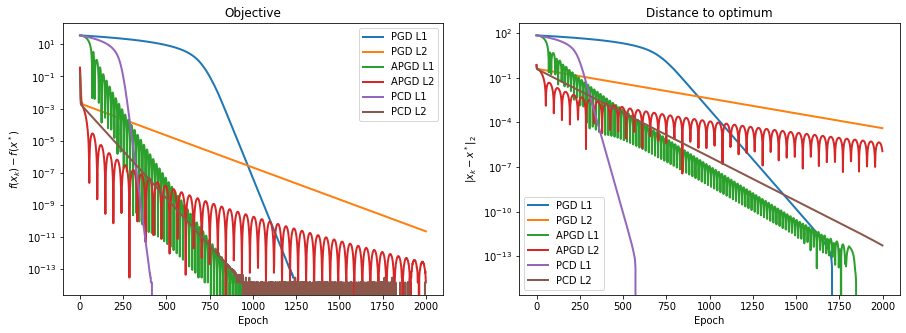

In [22]:
u = performance_comparison(4000,2)

<div class="alert alert-success">
    <b>QUESTION 9:</b>
    <ul>
    <li>
        Compare the performance of the different solvers for different (simulated) problem sizes.
    </li>
    <li>
        What solver would you recommend for what problem and using what regularization?
    </li>
    </ul>
</div>

We ran several convergence plots similar to the one above with different dataset sizes, and here are our results (we don't re-run all experiments here because it would take too long but feel free to check by using the above function).

$\underline{For~a~low~number~of~features:~(nb_{}features = 2~and~nb_{}samples = 8088):}$

- PGD L1 has the lowest convergence speed
- PGD L2 is getting close rapidly to $10^{-3}$ and then converges linearly 
- PCD L1 convergence's speed starts slowly but increases up to some threshold and then converges linearly but fast.
- APGD L1's curve has the same overall shape of PGDL1 (except the bounces). Their convergence speed is quite similar.
- APGD L2 starts very quickly and reach an objective accuracy of $10^{-9}$ with only 10 iterations but then the speed decreases a bit and follows a linear curve
- PCD L2 seems to be the best solution. The speed convergence is linear but with a really high coefficient making it the best solution for this problem.


This phenomenon of high convergence up to a threshold and then linear convergence on PCD's curves appears beacause the problem is not well conditionned. The highest and lowest singular values have a big difference is absolute value.

$\underline{For~a~big~number~of~features:~(nb_{}features = 20~and~nb_{}samples = 8088):}$

- PGD L1 and PGD L2 have a really low convergence speed. The speed is linear with a slope very close to $0$
- PCD L1 and PCD L2 have indistinguishable curves. The convergence is linear but fast making it the best solution for such a problem in comparision with the other ones
- APGD L1 and APGD L2 have also very close curves following exactly the same path. The convergence is quick at the begining and then gets slower. The overall shape follows a linear curve  with a slope a little bit smaller than PCD. The depth of the jumps is very big.

$\underline{For~a~smaller~number~of~samples:~(nb_{}features = 2~and~nb_{}samples = 4000):}$

- PGD L1's speed starts slowly but increases and gets linear and fast.
- PGD L2's is linear but pretty slow in comparision to the other ones.
- APGD L1's very fast. Its overall shape follows a linear curve but with a really high slope in absolute value.
- APGD L2 is also fast but its overall shape follows a linear curve with a smaller slope than APGD L1.
- PCD  L1 is the fastest solution. The convergence is linear with a really high slope. This is the best solution for such a problem.
- PCD L2 is also linear but less fast.

# Part 3: Application

You will now apply your solver to an environment dataset. Given 2 features:

 - LNOxEm log of hourly sum of NOx emission of cars on this motorway in arbitrary units.
 - sqrtWS Square root of wind speed [m/s].

The objective is to predict:

 - log of hourly mean of NOx concentration in ambient air [ppb] next to a highly frequented motorway

**Disclaimer:** This dataset is not huge and regularization makes little sense with so little features but it serves as a simple illustration. Also, don't be surprised if Huber loss offers little to no benefit. Again it's just an illustration.

Let's first inspect the dataset:

In [23]:
import pandas as pd

df = pd.read_csv('NOxEmissions.csv', index_col=0).drop(['julday'], axis=1)
df.head()

,LNOx,LNOxEm,sqrtWS
193,4.457250,5.536489,0.856446
194,4.151827,5.513000,1.016612
195,3.834061,4.886994,1.095445
196,4.172848,5.138912,1.354068
197,4.322807,5.666518,1.204159


Now let's extract `X` and `y`

In [24]:
X = df.loc[:, ['LNOxEm', 'sqrtWS']].values
y = df['LNOx']
X.shape, y.shape

((8088, 2), (8088,))

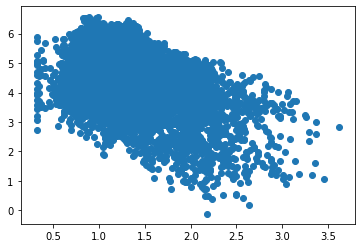

In [25]:
plt.scatter(X[:, 1], y);

In order to facilitate our experiment we're going to write a full scikit-learn estimator.

<div class="alert alert-success">
    <b>QUESTION 9:</b>
    <ul>
    <li>
        Implement the `fit` method from the estimator in the next cell
    </li>
    </ul>
</div>

In [29]:
from sklearn.base import BaseEstimator, RegressorMixin


class HuberRegressor(BaseEstimator, RegressorMixin):
    """scikit-learn estimator for regression with a Huber loss
    
    Parameters
    ----------
    lbda : float
        The regularization parameter
    penalty : 'l1' | 'l2'
        The type of regularization to use.
    max_iter : int
        The number of iterations / epochs to do on the data.
    solver : 'pgd' | 'apgd' | 'pcd'
        The type of algorithm to use.
        
    Attributes
    ----------
    coef_ : ndarray, (n_features,)
        The weitghs w.
    intercept_ : float
        The intercept or bias term b.
    """
    def __init__(self, lbda=1., penalty='l2', epsilon=1.,
                 max_iter=2000, solver='pgd'):
        self.lbda = lbda
        self.penalty = penalty
        self.epsilon = epsilon
        self.max_iter = max_iter
        self.solver = solver
        assert epsilon > 0.
        assert self.penalty in ['l1', 'l2']
        assert self.solver in ['pgd', 'apgd', 'pcd'] 

    def fit(self, X, y):
        """Fit method
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The features.
        y : ndarray, shape (n_samples,)
            The target.
        """
        n_samples, n_features = X.shape
        
        # TODO
        
        X = np.concatenate((np.ones((n_samples,1)),X),axis = 1)
        n_samples, n_features = X.shape

        x_init = np.zeros(n_features)
        x_init[0] = np.mean(y)
        
        
        L_huber = 2 
        L_loss = (L_huber / n_samples) * (X**2).sum()
        step = 1/L_loss

        L_loss = (L_huber / n_samples) * (X**2).sum(axis = 0)
        steps = 1/L_loss
    
        if self.penalty == 'l1':
            if self.solver =='pgd':
                x = pgd(x_init, grad_huber_loss, prox_l1, step, self.max_iter, grad_args=(X, y, self.epsilon), prox_args=(self.lbda,))[0]
            elif self.solver == 'apgd':
                x = apgd(x_init, grad_huber_loss, prox_l1, step, self.max_iter, grad_args=(X, y, self.epsilon), prox_args=(self.lbda,))[0]
            else:
                x = pcd(x_init, X, grad_huber_loss_j, prox_l1_1D, steps, self.max_iter, grad_args=(X, y, self.epsilon), prox_args=(self.lbda,))[0]

        elif self.penalty == 'l2':
            if self.solver =='pgd':
                x = pgd(x_init, grad_huber_loss, prox_l2, step, self.max_iter, grad_args=(X, y, self.epsilon), prox_args=(self.lbda,))[0]
            elif self.solver == 'apgd':
                x = apgd(x_init, grad_huber_loss, prox_l2, step, self.max_iter, grad_args=(X, y, self.epsilon), prox_args=(self.lbda,))[0]
            else:
                x = pcd(x_init, X, grad_huber_loss_j, prox_l2_1D, steps, self.max_iter, grad_args=(X, y, self.epsilon), prox_args=(self.lbda,))[0]
        # END TODO
        self.params_ = x
        self.coef_ = x[1:]
        self.intercept_ = x[0]
        return self

    def predict(self, X):
        """Predict method
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The features.

        Returns
        -------
        y_pred : ndarray, shape (n_samples,)
            The predicted target.
        """
        return np.dot(X, self.coef_) + self.intercept_

    
    def score(self, X, y):
        """Score using negative mean absolute error
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The features.
        y : ndarray, shape (n_samples,)
            The target.
            
        Returns
        -------
        score : float
            The negative mean absolute error.
            Negative to keep the semantic that higher is better.
        """
        return -np.mean(np.abs(y - self.predict(X)))


for solver in ['pgd', 'apgd', 'pcd']:
    clf = HuberRegressor(lbda=1., penalty='l2', max_iter=1000, solver=solver)
    clf.fit(X, y)
    print('Solver with L2: %s   \t-   MAE : %.5f' % (solver, -clf.score(X, y)))

for solver in ['pgd', 'apgd', 'pcd']:
    clf = HuberRegressor(lbda=1., penalty='l1', max_iter=1000, solver=solver)
    clf.fit(X, y)
    print('Solver with L1: %s   \t-   MAE : %.5f' % (solver, -clf.score(X, y)))

Solver with L2: pgd   	-   MAE : 0.62326
Solver with L2: apgd   	-   MAE : 0.57357
Solver with L2: pcd   	-   MAE : 0.57371
Solver with L1: pgd   	-   MAE : 0.71309
Solver with L1: apgd   	-   MAE : 0.71309
Solver with L1: pcd   	-   MAE : 0.71309


<div class="alert alert-success">
    <b>QUESTION 10:</b>
    <ul>
        <li>
            Compare the cross-validation performance of your model (using `cross_val_score`) with a Ridge or Lasso regression models using as scoring metric the "mean absolute error" (MAE).
        </li>
        <li>
            You will check that the Huber model matches Ridge when epsilon is large. Pay attention to how the loss is scaled in scikit-learn for Ridge (no normalization by 1/n_samples).
        </li>
        <li>
            You will comment on the running time of your solver to reach their optimal prediction performance.
        </li>
    </ul>
</div>

To score your model with MAE using cross_val_score you need to pass as parameter `scoring='neg_mean_absolute_error'`.

In [30]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_val_score

# TODO
clf_Huber_l1 = HuberRegressor(lbda=1./X.shape[0],penalty ='l1',max_iter = 1000,solver='apgd')
clf_Huber_l2 = HuberRegressor(lbda=1./X.shape[0],penalty ='l2',max_iter = 1000,solver='apgd')
clf_Ridge = Ridge(alpha = lbda,max_iter = 1000)
clf_Lasso = Lasso(alpha = 1./X.shape[0],max_iter = 1000)

mean_score_Huber_l1 = -np.mean(cross_val_score(clf_Huber_l1,X,y,scoring = 'neg_mean_absolute_error',cv =5))
mean_score_Huber_l2 = -np.mean(cross_val_score(clf_Huber_l2,X,y,scoring = 'neg_mean_absolute_error',cv=5))
mean_score_Ridge = -np.mean(cross_val_score(clf_Ridge,X,y,scoring = 'neg_mean_absolute_error',cv=5))
mean_score_Lasso = -np.mean(cross_val_score(clf_Lasso,X,y,scoring = 'neg_mean_absolute_error',cv=5))
# # END TODO

***Compare the cross-validation performance of your model (using `cross_val_score`) with a Ridge or Lasso regression models using as scoring metric the "mean absolute error" (MAE).*** 

In [31]:
print('CV score Huber L1:',mean_score_Huber_l1)
print('CV score Huber L2:',mean_score_Huber_l2)
print('CV score Ridge:',mean_score_Ridge)
print('CV score Lasso:',mean_score_Lasso)

CV score Huber L1: 0.4455470314975144
CV score Huber L2: 0.44554034115592545
CV score Ridge: 0.4451855171168334
CV score Lasso: 0.44519194886232655


Oddly enough we don't seed any improvement with our algorithm but rather very similar (and actually very slightly worse) results to Ridge or Lasso. The disclaimer at the beginning of this parts tells us that it's not surprising given the dataset we're using.

***You will check that the Huber model matches Ridge when epsilon is large. Pay attention to how the loss is scaled in scikit-learn for Ridge (no normalization by 1/n_samples).*** 

In [32]:
clf_Huber_l2 = HuberRegressor(lbda=1./X.shape[0],penalty ='l2',max_iter = 1000,solver='apgd',epsilon = 1000) # testing for eps big
mean_score_Huber_l2 = -np.mean(cross_val_score(clf_Huber_l2,X,y,scoring = 'neg_mean_absolute_error',cv=5))

In [33]:
print('CV score Huber L2:',mean_score_Huber_l2)
print('CV score Ridge:',mean_score_Ridge)

CV score Huber L2: 0.4450161404447498
CV score Ridge: 0.4451855171168334


We indeed see similar results for the L2 version of our solver and for Ridge when $\epsilon$ is big which is coherent with the fact that the Huber loss closely resembles the Ridge loss when $\epsilon$ is large.

***You will comment on the running time of your solver to reach their optimal prediction performance.***

This question is a bit vague and we did not really know how to give interesting elements. 

* A first remark is that if we change the solver used for our Huber regressor, say we use PCD instead of APGD, then we do not get a better score (this can be tried by changing 'apgd' to 'pcd' in the cells above for the Huber regressors and printing the results again). This means that there is an optimal result common to all solvers, and that this result is reached much faster with APGD than with PCD. However, the analysis we did on Question 9 suggests that this may vary depending on the dataset dimensions we're facing. 

* If we want to go further, let's look at some timing performance, using the comparison tools we used before and timing the result:

In [35]:
clf_Huber_l1_apgd = HuberRegressor(lbda=1.,penalty ='l1',max_iter = 5000,solver='apgd')
clf_Huber_l1_pgd = HuberRegressor(lbda=1.,penalty ='l1',max_iter = 5000,solver='pgd')
clf_Huber_l1_pcd = HuberRegressor(lbda=1.,penalty ='l1',max_iter = 5000,solver='pcd')

clf_Huber_l2_apgd = HuberRegressor(lbda=1.,penalty ='l2',max_iter = 5000,solver='apgd')
clf_Huber_l2_pgd = HuberRegressor(lbda=1.,penalty ='l2',max_iter = 5000,solver='pgd')
clf_Huber_l2_pcd = HuberRegressor(lbda=1.,penalty ='l2',max_iter = 5000,solver='pcd')

In [39]:

t0 = time.time()
clf_Huber_l1_apgd.fit(X,y)
t1 = time.time()
clf_Huber_l1_pgd.fit(X,y)
t2 = time.time()
clf_Huber_l1_pcd.fit(X,y)
t3 = time.time()

print('fitting the Huber Regressor with L1 regularisation takes {} seconds with {}'.format((t1-t0),'apgd'))
print('fitting the Huber Regressor with L1 regularisation takes {} seconds with {}'.format((t2-t1),'pgd'))
print('fitting the Huber Regressor with L1 regularisation takes {} seconds with {}'.format((t3-t2),'pcd'))

fitting the Huber Regressor with L1 regularisation takes 45.43790316581726 seconds with apgd
fitting the Huber Regressor with L1 regularisation takes 41.65618538856506 seconds with pgd
fitting the Huber Regressor with L1 regularisation takes 128.95004153251648 seconds with pcd


APGD and PGD take approximately the same time to compute 5000 iterations and PCD takes way much more time. However let's now compare the algorithms by the time necessary to reach their optimal value. To do this we are going to  take a stopping criterion $\epsilon$.

In [66]:
def performance_comparison_example():
        # Generate bigger data
    X = df.loc[:, ['LNOxEm', 'sqrtWS']].values
    N_samples = X.shape[0]
    y = df['LNOx']
    X = np.concatenate((np.ones((N_samples,1)),X),axis = 1)
    n_samples, n_features = X.shape

    # Set initial values of parameters to optimize
    x_init = np.zeros(n_features)
    x_init[0] = np.mean(y)
    n_iter = 2000
    lbda = 1.
    epsilon = 1.


    L_huber = 2 # smoothness constant of the Huber function 
    L_loss = (L_huber / n_samples) * (X**2).sum()
    step = 1/L_loss

    L_loss = (L_huber / n_samples) * (X**2).sum(axis = 0)
    steps = 1/L_loss


    x_min_pgd_l1 = pgd(x_init, grad_huber_loss, prox_l1, step, 10000,
                       grad_args=(X, y, epsilon), prox_args=(lbda,))[0]
    monitor_pgd_l1 = monitor(pgd, pobj_l1, x_min = x_min_pgd_l1, args=(X, y, lbda,epsilon))
    monitor_pgd_l1.run(x_init, grad_huber_loss, prox_l1, step, n_iter,
                       grad_args=(X, y,epsilon), prox_args=(lbda,))

    x_min_apgd_l1 = apgd(x_init, grad_huber_loss, prox_l1, step, 10000,
                       grad_args=(X, y,epsilon), prox_args=(lbda,))[0]
    monitor_apgd_l1 = monitor(apgd, pobj_l1, x_min_apgd_l1, args=(X, y, lbda,epsilon))
    monitor_apgd_l1.run(x_init, grad_huber_loss, prox_l1, step, n_iter,
                       grad_args=(X, y, epsilon), prox_args=(lbda,))

    x_min_pcd_l1 = pcd(x_init, X, grad_huber_loss_j, prox_l1_1D, steps, 10000,
                       grad_args=(X, y, epsilon), prox_args=(lbda,))[0]
    monitor_pcd_l1 = monitor(pcd, pobj_l1, x_min_pcd_l1, args=(X, y, lbda, epsilon))
    monitor_pcd_l1.run(x_init, X, grad_huber_loss_j, prox_l1_1D, steps, n_iter,
                       grad_args=(X, y, epsilon), prox_args=(lbda,))

    monitors = [monitor_pgd_l1, monitor_apgd_l1, monitor_pcd_l1]
    solvers = ["PGD L1","APGD L1","PCD L1"]
    plot_epochs(monitors,solvers)

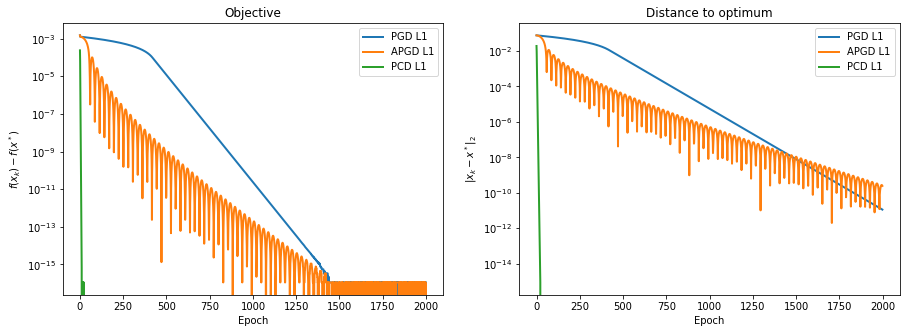

In [67]:
performance_comparison_example()

let say $\epsilon = 10^{-9}$:

Then to reach such a convergence, PGD needs **800** iterations to reach such a minimum whereas APGD needs approximately **500** iterations and finally PCD is very effective with only just a few iterations, **less than 10**.

- This can be explained by the fact that the solution is very sparse and since a single iteration of pcd only modify one coordinate then the algorithm is very fast.

- Here are the corresponding times:

In [68]:
clf_Huber_l1_apgd = HuberRegressor(lbda=1.,penalty ='l1',max_iter = 500,solver='apgd')
clf_Huber_l1_pgd = HuberRegressor(lbda=1.,penalty ='l1',max_iter = 800,solver='pgd')
clf_Huber_l1_pcd = HuberRegressor(lbda=1.,penalty ='l1',max_iter = 10,solver='pcd')


t0 = time.time()
clf_Huber_l1_apgd.fit(X,y)
t1 = time.time()
clf_Huber_l1_pgd.fit(X,y)
t2 = time.time()
clf_Huber_l1_pcd.fit(X,y)
t3 = time.time()

print('fitting the Huber Regressor with L1 regularisation takes {} seconds with {}'.format((t1-t0),'apgd'))
print('fitting the Huber Regressor with L1 regularisation takes {} seconds with {}'.format((t2-t1),'pgd'))
print('fitting the Huber Regressor with L1 regularisation takes {} seconds with {}'.format((t3-t2),'pcd'))

fitting the Huber Regressor with L1 regularisation takes 4.870973825454712 seconds with apgd
fitting the Huber Regressor with L1 regularisation takes 7.380263090133667 seconds with pgd
fitting the Huber Regressor with L1 regularisation takes 0.25032997131347656 seconds with pcd
